# JHU covid-19 analysis
Log plot of cases per state 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import glob
import os
import matplotlib.ticker as mticker
import matplotlib.dates as mdates 
from datetime import timedelta
import datetime
import pytz
from tzwhere import tzwhere
import JHUprocessing as jp
from matplotlib.dates import date2num       #-->Update 
from matplotlib.colors import ListedColormap


In [2]:
# general parameters

In [3]:
full_w = (12,7)
half_w = (6,4)

# load daily reports 

In [4]:
daily_path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports'
 
    
def load_daily_reports( file_path):
    
    daily_reports = glob.glob(file_path + '\*.csv') 
    df = pd.DataFrame()
    for file in daily_reports :
        df_temp = pd.read_csv( file, index_col=None, header=0)  

        if  '03-13-2020' in file :
            # correct for mistake in JHU data set
            df_temp['Last Update'] = pd.to_datetime(df_temp['Last Update']   )
            df_temp['Last Update'] = df_temp['Last Update'] + timedelta(days=2)  

        if  '03-09-2020' in file : 
            # correct for mistake in JHU data set
            df_temp['Last Update'] = pd.to_datetime(df_temp['Last Update']   )
            df_temp['Last Update'] = df_temp['Last Update'] + timedelta(days=1) 

        df = df.append(df_temp, sort=True)  
    return df

df_daily = load_daily_reports( daily_path )
 

# adjust column names and use only relevant columns

In [5]:


def replace_state( x):
    
    error_dict = {'Chicago':'Illinois',
            'NE (From Diamond Princess)':'Nebraska',
            'CA (From Diamond Princess)':'California',
            'TX (From Diamond Princess)':'Texas',
            'Unassigned Location (From Diamond Princess)':'Other',
            'D.C.':'District of Columbia',
            'Puerto Rico':'Other',
            'Guam':'Other',
            'U.S.':'Other',
            'US':'Other',
            'Virgin Islands':'Other',
            'United States Virgin Islands':'Other',
            'Wuhan Evacuee':'Other',
            'American Samoa':'Other',
            'Northern Mariana Islands':'Other', 
            'OR ':'Oregon'} 
    
    state_entry = x['Province/State'].split(", ")[-1] 
    if state_entry in jp.state_dict.keys(): 
        new = jp.state_dict[ state_entry]  
    elif state_entry in error_dict.keys():
        new = error_dict[state_entry]  
    else:
        new = state_entry   
    return new 

def process_daily_data( df_daily):
    # convert both separately 
    df_daily['Last Update'] = pd.to_datetime(df_daily['Last Update']   )
    df_daily['Last_Update'] = pd.to_datetime(df_daily['Last_Update']   )   # 
    cond = df_daily['Last_Update'].isnull()
    df_daily['Last Update'] = df_daily['Last Update'].where(cond, df_daily['Last_Update'] ) 
    df_daily['Datetime'] = pd.to_datetime(df_daily['Last Update'] , unit='D'   ) 

    ### optional: convert times to pacific time 
    df_daily['Date'] = df_daily['Datetime'].dt.date 


    # compensate country/region
    df_daily['Country/Region'].isnull().sum() 
    cond = df_daily['Country_Region'].isnull()
    df_daily['Country/Region'] = df_daily['Country/Region'].where(cond, df_daily['Country_Region'] ) 

    # province state
    cond = df_daily['Province_State'].isnull()
    df_daily['Province/State'] = df_daily['Province/State'].where(cond, df_daily['Province_State'] ) 


    col_order = ['Date','Country/Region','Province/State','Active','Confirmed','Deaths','Recovered' ]
    df_daily = df_daily[col_order]
    
    bool_US = df_daily['Country/Region'] =='US'
    df_US = df_daily[bool_US ]



    df_US.loc[:,'State'] = df_US.apply(replace_state, axis=1)
    
    
    df_state =  df_US.groupby(['State','Date']).sum().reset_index()
  
    df_state = df_state.sort_values(by=['State','Date'], ascending=True )  
    df_state.head() 
 
    # drop some states
    bool_other = df_state['State'].str.contains( 'Other' , regex=False) 
    df_state.drop( df_state[bool_other].index, inplace=True)  
  
    bool_other = df_state['State'].str.contains( 'Princess' , regex=False) 
    df_state.drop( df_state[bool_other].index, inplace=True)  


    return df_state 

df_state = process_daily_data( df_daily )
# df.tail()
df_state.tail()

D:\D_program_files\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\D_program_files\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,State,Date,Active,Confirmed,Deaths,Recovered
1783,Wyoming,2020-04-05,0.0,197.0,0.0,0.0
1784,Wyoming,2020-04-06,0.0,210.0,0.0,0.0
1785,Wyoming,2020-04-07,0.0,216.0,0.0,0.0
1786,Wyoming,2020-04-08,0.0,221.0,0.0,0.0
1787,Wyoming,2020-04-09,0.0,230.0,0.0,0.0


# adjust california

In [6]:
bool_cal = df_state['State'] == 'California'
bool_prior = df_state['Date'] < datetime.datetime(2020,2,10).date() 

df_state.loc[bool_cal & bool_prior,'Confirmed'] = 0 

# find day 0

In [7]:
threshold_cases = 100
threshold_deaths = 10

df_state['Delta C'] =  jp.days_since_threshold( df_state['Date'],
                                df_state['Confirmed'],
                                df_state['State'] , 
                                threshold_cases) 

df_state['Delta D'] = jp.days_since_threshold( df_state['Date'],
                                df_state['Deaths'],
                                df_state['State'] , 
                                threshold_deaths)
    
df_state.tail()

,State,Date,Active,Confirmed,Deaths,Recovered,Delta C,Delta D
1783,Wyoming,2020-04-05,0.0,197.0,0.0,0.0,5.0,-5.0
1784,Wyoming,2020-04-06,0.0,210.0,0.0,0.0,6.0,-4.0
1785,Wyoming,2020-04-07,0.0,216.0,0.0,0.0,7.0,-3.0
1786,Wyoming,2020-04-08,0.0,221.0,0.0,0.0,8.0,-2.0
1787,Wyoming,2020-04-09,0.0,230.0,0.0,0.0,9.0,-1.0


In [8]:
# find ratio and doubling # days
averaging_period = 3

bin_array = np.array( [0, 2.**(1./8), 2.**(1./7), 2.**(1./6), 2.**(1./5), 2.**(1./4) ,np.inf ]) 
bin_tick_labels = ['8','7','6','5','4']
df_state['ratio'] = jp.get_exponential_ratio( df_state['Date'], 
                                            df_state['Confirmed'],
                                            df_state['State'], 
                                            averaging_period )   
df_state['doubling'] = pd.cut( df_state['ratio'],   bin_array ,labels=range(len(bin_array)-1) , include_lowest=True )

df_state['ratioD'] = jp.get_exponential_ratio( df_state['Date'], 
                                            df_state['Deaths'],
                                            df_state['State'], 
                                            averaging_period )  
df_state['doublingD'] = pd.cut( df_state['ratioD'],   bin_array ,labels=range(len(bin_array)-1) , include_lowest=True )

 

In [20]:

try_bool = df_state.groupby('State').max()['Delta C'] > 0 
threshold_states = try_bool.index[try_bool].tolist()
 

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

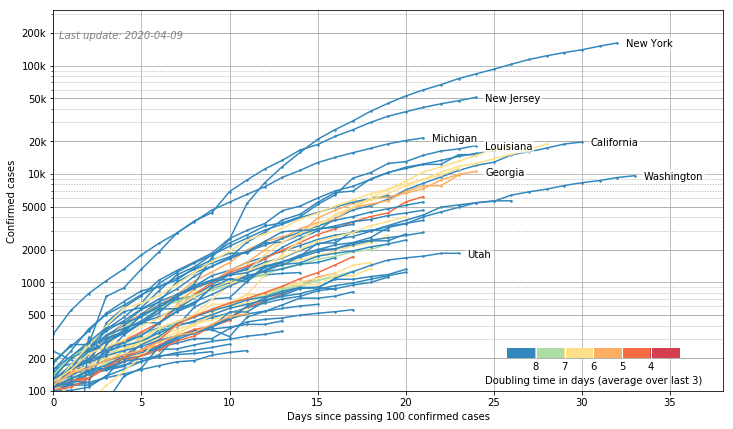

In [11]:
cols = np.array([[213,62,79],
[244,109,67],
[253,174,97],
[254,224,139], 
[171,221,164], 
[50,136,189]]) /255 
cols = np.flipud(cols)

try_bool = df_state.groupby('State').max()['Delta C'] > 0 
threshold_states = try_bool.index[try_bool].tolist()
    
bbox_props = dict(boxstyle="round,pad=0.1", fc="w", ec="w", lw=2, alpha = 0.5)

notable_states = ['New York','New Jersey','Michigan',"California",'Washington','Louisiana','Georgia','Utah' ]
# notable_states = threshold_states

fig, ax = plt.subplots(1,1 ,figsize= full_w )  
     
    
xCmax = df_state['Delta C'].max()
yCmax = df_state['Confirmed'].max()
xDmax = df_state['Delta D'].max()
yDmax = df_state['Deaths'].max()


for state in threshold_states:
    bool_state = df_state['State'] == state 
    df_pl = df_state[bool_state] 
    
    
    doubling_category = df_pl['doubling'].iloc[0]
    pl1 = ax.plot( df_pl['Delta C' ],  df_pl['Confirmed'],
            '.-' ,ms=3,lw=1.5, label=state,
               color = cols[doubling_category])
      
    y = df_pl['Confirmed'].iloc[-1]*0.98
    x = df_pl['Delta C'].iloc[-1] + 0.5      
       
    print( )
    if (state in notable_states) & (0 <=  x <= xCmax+10) & (10<= y <= yCmax*2): 
        t = ax.text(x,y,state, ha="left", va="center" ,  bbox=bbox_props)
         
ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
ax.grid(True,which="minor", linestyle=':', color=[.5,.5,.5],linewidth=0.6)   
 

ax.yaxis.set_ticks([1e2,2e2,5e2,1e3,2e3,5e3,1e4,2e4,5e4,1e5,2e5,5e5,1e6,2e6,5e6,])
ax.yaxis.set_ticklabels([100,200,500, 1000,2000,5000, '10k','20k','50k', '100k','200k','500k','1m','2m','5m'])

ax.set_xlim([0,xCmax+5])
ax.set_ylim([100,yCmax*2])

ax.set_xlabel("Days since passing "+ str(threshold_cases) + " confirmed cases") 
ax.set_ylabel("Confirmed cases") 

ax.annotate('Last update: '+str( df_state['Date'].iloc[-1]), 
            [.3,round(yCmax,5)*1.1], color=[.5,.5,.5], style='italic')


cmap = ListedColormap(cols)
xy = []
sc = plt.scatter(xy, xy, c=xy, vmin=0, vmax=1, cmap=cmap)
cax = fig.add_axes([0.65, 0.19, 0.2, 0.02])
cb = plt.colorbar(sc, cax = cax, orientation='horizontal') 

cb.set_ticks(np.linspace(1/6,1,6)) 
cb.set_ticklabels(bin_tick_labels) 
cb.set_label('Doubling time in days (average over last 3)')
cb.outline.set_visible(False)

cb.ax.tick_params(which='major', length=15, width=1, direction='in',color='w')


# # # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_state_caseslog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  

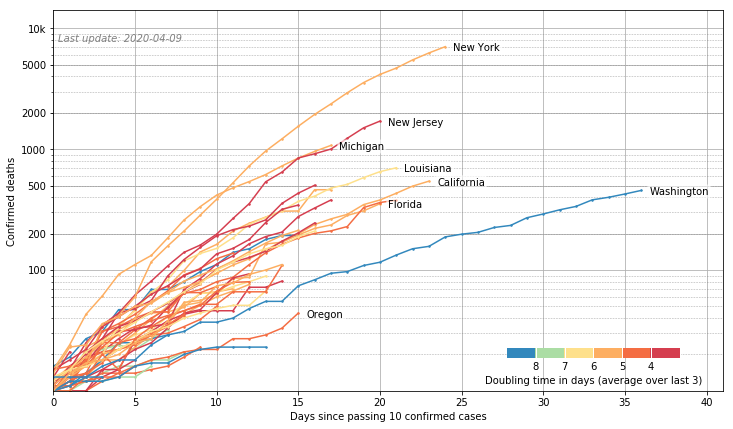

In [12]:
cols = np.array([[213,62,79],
[244,109,67],
[253,174,97],
[254,224,139], 
[171,221,164], 
[50,136,189]]) /255 
cols = np.flipud(cols)

bbox_props = dict(boxstyle="round,pad=0.1", fc="w", ec="w", lw=2, alpha = 0.5)

notable_states =   ['New York','New Jersey','Michigan',"California",'Washington','Louisiana',"Florida","Oregon"]
# notable_states = threshold_states

fig, ax = plt.subplots(1,1 ,figsize= full_w )  
     
xDmax = df_state['Delta D'].max()
yDmax = df_state['Deaths'].max()

for state in threshold_states:
    bool_state = df_state['State'] == state 
    df_pl = df_state[bool_state] 
    
    
    doubling_category = df_pl['doublingD'].iloc[0]
    pl1 = ax.plot( df_pl['Delta D' ],  df_pl['Deaths'],
            '.-' ,ms=3,lw=1.5, label=state,
               color = cols[doubling_category])
       
    y = df_pl['Deaths'].iloc[-1]*0.98
    x = df_pl['Delta D'].iloc[-1] + 0.5         
        
    if (state in notable_states) & (0 <=  x <= xCmax+10) & (10<= y <= yCmax*2): 
        t = ax.text(x,y,state, ha="left", va="center" ,  bbox=bbox_props)
          
ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
ax.grid(True,which="minor", linestyle=':', color=[.5,.5,.5],linewidth=0.6)   



ax.yaxis.set_ticks([1e2,2e2,5e2,1e3,2e3,5e3,1e4,2e4,5e4,1e5,2e5,5e5,1e6,2e6,5e6,])
ax.yaxis.set_ticklabels([100,200,500, 1000,2000,5000, '10k','20k','50k', '100k','200k','500k','1m','2m','5m'])

ax.set_xlim([0,xDmax+5])
ax.set_ylim([10,yDmax*2])

ax.set_xlabel("Days since passing "+ str(threshold_deaths)+ " confirmed cases") 
ax.set_ylabel("Confirmed deaths") 

ax.annotate('Last update: '+str( df_state['Date'].iloc[-1]), 
            [.3,round(yDmax,5)*1.1], color=[.5,.5,.5], style='italic')


cmap = ListedColormap(cols)
xy = []
sc = plt.scatter(xy, xy, c=xy, vmin=0, vmax=1, cmap=cmap)
cax = fig.add_axes([0.65, 0.19, 0.2, 0.02])
cb = plt.colorbar(sc, cax = cax, orientation='horizontal') 

cb.set_ticks(np.linspace(1/6,1,6)) 
cb.set_ticklabels(bin_tick_labels) 
cb.set_label('Doubling time in days (average over last 3)')
cb.outline.set_visible(False)

cb.ax.tick_params(which='major', length=15, width=1, direction='in',color='w')


# # # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_state_deathslog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  

In [13]:
# sort states by confirmed cases on last date
bool_last = df_state['Date'] == df_state['Date'].max()
sorted_states = df_state[bool_last].sort_values(by=['Confirmed'], ascending=False )    
sorted_states.head(5)  

sorted_names = sorted_states['State'].tolist()

sorted_names[:5]

['New York', 'New Jersey', 'Michigan', 'California', 'Massachusetts']

In [14]:
# df_state

# Highlight states

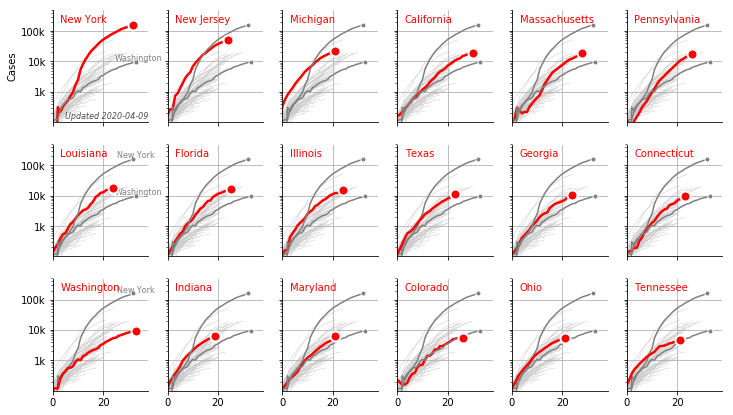

In [15]:
dot_col = np.ones((3))*0.8 
emph_col = [0.5,0.5,0.5]
goal_col = 'red'

dot_alpha = 1


notable_states = ['New York', 'Washington'  ]

def plot_highlight( ax_p, goal_state, df_state_pl):
    
    cmax = df_state_pl['Confirmed'].max()
    xCmax = df_state_pl['Delta C'].max()

    for state in threshold_states:
    #     print(state)
        if state == goal_state:
            bool_state = df_state_pl['State'] == state 
            df_pl = df_state_pl[bool_state] 
            ax_p.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'-' ,
                    ms=3,lw=2.5, label=state, 
                    color=goal_col ,alpha = dot_alpha) 
            ax_p.scatter( df_pl['Delta C' ].iloc[-1],  df_pl['Confirmed'].iloc[-1], 100, goal_col,
                         edgecolors='w',zorder = 5, linewidths=2)  
            
            ax_p.annotate( state ,[3,cmax*1.2], color=goal_col, fontsize = 10,zorder = 5)
            
        elif state in notable_states:
#             print(state)
            bool_state = df_state_pl['State'] == state 
            df_pl = df_state_pl[bool_state] 
            ax_p.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'-' ,
                    ms=3,lw=1.5, label=state, 
                    color=emph_col ,zorder = 2 ) 
            ax_p.plot( df_pl['Delta C' ].iloc[-1],  df_pl['Confirmed'].iloc[-1], marker='.',
                      markersize=10, markerfacecolor=emph_col , 
                    markeredgecolor='w',markeredgewidth=1,zorder =3 ) 
        else:
            bool_state = df_state_pl['State'] == state 
            df_pl = df_state_pl[bool_state] 
            ax_p.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'-' ,
                    ms=3,lw=.5, label=state, 
                    color=dot_col ,alpha = dot_alpha,zorder = 1) 
             
    ax_p.set_yscale('log') 
    
    ax_p.yaxis.set_ticks([ 1e3,1e4,1e5,1e6])
    ax_p.yaxis.set_ticklabels([ '1k','10k','100k','1M'])
    
    ax_p.set_xlim([0,xCmax+5])
    ax_p.set_ylim([100,cmax*3])
    
    return ax_p

dy = 3
dx = 6
fig, ax = plt.subplots( dy,dx ,figsize=full_w)
 
for i, (ax_1, goal_state) in enumerate( zip(ax.reshape(-1), sorted_names[:(dy*dx)])): 
    ax_1 = plot_highlight(ax_1, goal_state, df_state)  
    ax_1 .grid(True )  
    
    if np.mod(i,dx) ==0:
        for state in threshold_states:
            if (state in notable_states) &( state not in goal_state):
                bool_state = df_state['State'] == state 
                df_pl = df_state[bool_state] 

                y = df_pl['Confirmed'].iloc[-1]*1.1
                x = df_pl['Delta C'].iloc[-1] + 1 
                ax_1.annotate( state ,[x,y], color=emph_col, fontsize = 8, ha='center')
    else: 
        ax_1.axes.get_yaxis().set_ticklabels([])
    if i< (dy-1)*dx:
        ax_1.axes.get_xaxis().set_ticklabels([])
        
        
    ax_1.axes.get_yaxis().set_ticks([1e3,1e4,1e5])
    ax_1.spines['top'].set_visible(False)
    ax_1.spines['right'].set_visible(False)
    
ax[0,0].set_ylabel('Cases')

ax[0,0].annotate('Updated '+str( df_state['Date'].iloc[-1]), 
            [5,130], color=[.3,.3,.3], style='italic',fontsize=8)

# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_state_casesHighlightLog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  

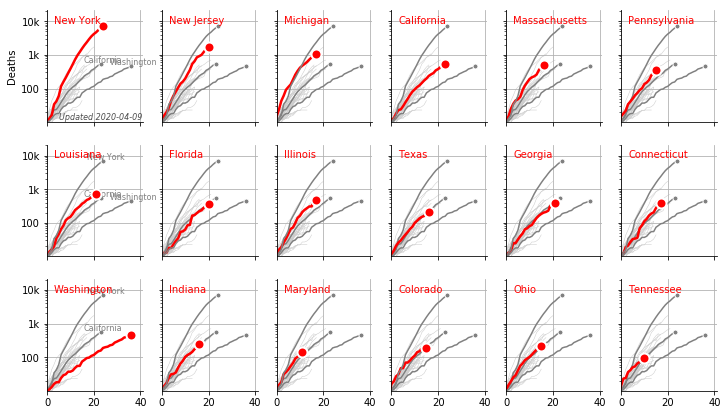

In [16]:
dot_col = np.ones((3))*0.8 
emph_col = [0.5,0.5,0.5]
goal_col = 'red'
 
notable_states = ['New York' ,'Washington', 'California' ]

def plot_highlight( ax_p, goal_state, df_state_pl):
    
    cmax = df_state_pl['Deaths'].max()
    xDmax = df_state_pl['Delta D'].max()

    for state in threshold_states:
    #     print(state)
        if state == goal_state:
            bool_state = df_state_pl['State'] == state 
            df_pl = df_state_pl[bool_state] 
            ax_p.plot( df_pl['Delta D' ],  df_pl['Deaths'],'-' ,
                    ms=3,lw=2.5, label=state, 
                    color=goal_col ,alpha = dot_alpha) 
            ax_p.scatter( df_pl['Delta D' ].iloc[-1],  df_pl['Deaths'].iloc[-1], 100, goal_col,
                         edgecolors='w',zorder = 5, linewidths=2)  
            
            ax_p.annotate( state ,[3,cmax*1.2], color=goal_col, fontsize = 10,zorder = 5)
            
        elif state in notable_states:
#             print(state)
            bool_state = df_state_pl['State'] == state 
            df_pl = df_state_pl[bool_state] 
            ax_p.plot( df_pl['Delta D' ],  df_pl['Deaths'],'-' ,
                    ms=3,lw=1.5, label=state, 
                    color=emph_col ,zorder = 2 ) 
            ax_p.plot( df_pl['Delta D' ].iloc[-1],  df_pl['Deaths'].iloc[-1], marker='.',
                      markersize=10, markerfacecolor=emph_col , 
                    markeredgecolor='w',markeredgewidth=1,zorder =3 ) 
        else:
            bool_state = df_state_pl['State'] == state 
            df_pl = df_state_pl[bool_state] 
            ax_p.plot( df_pl['Delta D' ],  df_pl['Deaths'],'-' ,
                    ms=3,lw=.5, label=state, 
                    color=dot_col ,alpha = dot_alpha,zorder = 1) 
             
    ax_p.set_yscale('log') 
    
    ax_p.yaxis.set_ticks([ 100,1e3,1e4,1e5,1e6])
    ax_p.yaxis.set_ticklabels(['100', '1k','10k','100k','1M'])
    
    ax_p.set_xlim([0,xDmax+5])
    ax_p.set_ylim([10,cmax*3])
#     ax_p.set_ylim([10,3e4])
    
    return ax_p

dy = 3
dx = 6
fig, ax = plt.subplots( dy,dx ,figsize=full_w)
 
for i, (ax_1, goal_state) in enumerate( zip(ax.reshape(-1), sorted_names[:(dy*dx)])): 
    ax_1 = plot_highlight(ax_1, goal_state, df_state)  
    ax_1 .grid(True )  
    
    if np.mod(i,dx) ==0:
        for state in threshold_states:
            if (state in notable_states) &( state not in goal_state):
                bool_state = df_state['State'] == state 
                df_pl = df_state[bool_state] 

                y = df_pl['Deaths'].iloc[-1]*1.1
                x = df_pl['Delta D'].iloc[-1] + 1 
                ax_1.annotate( state ,[x,y], color=emph_col, fontsize = 8, ha='center')
    else: 
        ax_1.axes.get_yaxis().set_ticklabels([])
    if i< (dy-1)*dx:
        ax_1.axes.get_xaxis().set_ticklabels([])
        
        
#     ax_1.axes.get_yaxis().set_ticks([1e2,1e3 ])
    ax_1.spines['top'].set_visible(False)
    ax_1.spines['right'].set_visible(False)
ax[0,0].set_ylabel('Deaths')

ax[0,0].annotate('Updated '+str( df_state['Date'].iloc[-1]), 
            [5,12], color=[.3,.3,.3], style='italic',fontsize=8)

# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_state_deathsHighlightLog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  

In [17]:
df_state['Deaths'].max()

7067.0